# final algorithm design

### In this notebook, 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.path.abspath("../"))  # or "." or ".." depending on your structure

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from models.model_utils import mask_observations, params
from models.linear_model import LinearModel_Estimator
from calibrator_module.BCUC_calibrator_finalVersion import BCUC_Calibrator
from models.model_utils import params
from calibrator_module.NLL_gradient_descent_calibrator import NLLGD_Calibrator


In [61]:

!python ../observation_generation.py --dir_path "../observations/second_person" --format npz --initial_Q 0.5


Creating linear system...
[[0.7]]

Generating observations for random_zeros_and_actions actions...
Generated 10001 observations
Observation shape: (1,)
Data saved as ../observations/second_person/observations_random_zeros_and_actions_for_Q0.7_initialModel_0.5.npz
Model parameters saved as ../observations/second_person/observations_random_zeros_and_actions_for_Q0.7_initialModel_0.5_params.json
Observation mean: [2.97343414]
Observation std: [2.75980433]
Observation generation complete!

Recommended workflow:
1. Use .npz format for numerical analysis in Python
2. Use .csv format for analysis in Excel or pandas
3. Use .json format for human-readable debugging
4. Use .mat format for MATLAB interoperability


In [57]:
# --- load data ---
from models.model_utils import params
data = np.load("../observations/second_person/observations_random_zeros_and_actions_for_Q0.7_initialModel_0.5.npz")
masked_observations = mask_observations(data['observations'])
actions = data['actions']

# --- build model ---
patient_1_model = LinearModel_Estimator(**params)   # e.g., Q_initial = 0.1
print(f"Initial Q matrix: {patient_1_model.Q}")
print("Target (true) Q*: 0.7")

# --- 1) B-CUC: quantile-coupled (q_t -> anchored Q) ---
cal_qc = BCUC_Calibrator(
    initial_model=patient_1_model,
    alpha=0.32,          # μ±σ target; keeps Q identification unbiased if Gaussian
)
model_qc = cal_qc.calibrate_model(masked_observations, actions)
metrics_qc = cal_qc.get_metrics()
print("\n[BCUC quantile_coupled]")
print("metrics:", metrics_qc)
print("final Q:", model_qc.Q)

# # --- 2) B-CUC: quantile-free (update Q directly from coverage error) ---
# patient_1_model2 = LinearModel_Estimator(**params)  # fresh copy
# cal_qf = BCUC_Calibrator(
#     initial_model=patient_1_model2,
#     alpha=0.32,          # with μ±σ evaluation, this aims at natural 68% coverage
#     mode="quantile_free",
# )
# model_qf = cal_qf.calibrate_model(masked_observations, actions)
# metrics_qf = cal_qf.get_metrics()
# print("\n[BCUC quantile_free]")
# print("metrics:", metrics_qf)
# print("final Q:", model_qf.Q)

# # --- Optional: NLL baseline (no quantile) for comparison ---
# # from wherever you placed the class I sent:
# # from calibrators.nllgd import NLLGD_Calibrator
# patient_1_model3 = LinearModel_Estimator(**params)  # fresh copy
# cal_nll = NLLGD_Calibrator(
#     initial_model=patient_1_model3,
#     eta_Q=1e-4,       # was 1e-2 → 100× smaller
#     kappa=0.1,        # sensitivity damped
#     clip_grad=0.05,   # keep updates small
#     ema_beta=0.9,     # smooth the grad a bit
# )
# model_nll = cal_nll.calibrate_model(masked_observations, actions)
# metrics_nll = cal_nll.get_metrics()
# print("\n[NLLGD baseline]")
# print("metrics:", metrics_nll)
# print("final Q:", model_nll.Q)

# --- sanity: are the returned models different objects? ---
print("\nObject identity checks:")
print("quantile_coupled returns same object?", patient_1_model is model_qc)


Initial Q matrix: [[0.1]]
Target (true) Q*: 0.7
e_t:0, mean_error = 0.0
Computed eta: 0.020929481092505104, eta_max: 0.5
Max score: 0.20929481092505103
Conditional distribution mean: [10.01791428], obs: [10.01791428], conditional variance: [[0.]]
e_t:1, mean_error = 0.5
Computed eta: 0.13953628790212477, eta_max: 0.5
Max score: 1.3953628790212476
Conditional distribution mean: [10.30532779], obs: [10.30532779], conditional variance: [[0.]]
e_t:1, mean_error = 0.6666666666666666
Computed eta: 0.13953628790212477, eta_max: 0.5
Max score: 1.3953628790212476
Conditional distribution mean: [10.38242786], obs: [10.38242786], conditional variance: [[0.]]
e_t:1, mean_error = 0.75
Computed eta: 0.5, eta_max: 0.5
Max score: 5.330911566521053
Conditional distribution mean: [9.79758244], obs: [9.79758244], conditional variance: [[0.]]
e_t:1, mean_error = 0.8
Computed eta: 0.5, eta_max: 0.5
Max score: 5.330911566521053
Conditional distribution mean: [10.44253466], obs: [10.44253466], conditional va

In [58]:
# --- plot results ---
metrics_qc = cal_qc.get_metrics()
print("\n[BCUC quantile_coupled]")
print("metrics:", metrics_qc)
print("final Q:", model_qc.Q)

# metrics_qf = cal_qf.get_metrics()
# print("\n[BCUC quantile_free]")
# print("metrics:", metrics_qf)
# print("final Q:", model_qf.Q)

# metrics_nll = cal_nll.get_metrics()
# print("\n[NLLGD baseline]")
# print("metrics:", metrics_nll)
# print("final Q:", model_nll.Q)


[BCUC quantile_coupled]
metrics: {'E_bar': 0.3121761658031088, 'coverage': 0.6878238341968912, 'mean_interval_width': 0.5427879174926613, 'avg_nll': 0.32354773189806557}
final Q: [[0.66766735]]


In [33]:
data['observations'].size

1001

In [59]:
Q_vals_qc = cal_qc.Q_history
# Q_vals_qf = cal_qf.Q_history
# Q_vals_nll = cal_nll.Q_history

q_vals_qc = cal_qc.q_history
# q_vals_qf = cal_qf.q_history #should be 1 always - just for sanity check

interval_widths_qc = cal_qc.interval_widths
# interval_widths_qf = cal_qf.interval_widths
# interval_widths_nll = cal_nll.interval_widths

E_qc = cal_qc.conformal_p_control.E
# E_qf = cal_qf.conformal_p_control.E
# E_null = [1 - h for h in cal_nll.coverage_hits]

interval_widths_with_correction_qc = [val*q for val, q in zip(interval_widths_qc, q_vals_qc)]
sigma_qc = [std/2 for std in interval_widths_with_correction_qc] #this is the vlaues of the std but calculated right after the prediction 
#step (without the update step in case of observation available)
# #it is necessary to follow this value to evaluate our calibration mechanism (we can check the interval width and cover precision)
# sigma_qf = [std/2 for std in interval_widths_qf]
# sigma_null = [std/2 for std in interval_widths_nll]

meu_qc = [dictionary['mean'].flatten() for dictionary in model_qc.dist_estimates]
std_qc = [np.sqrt(dictionary['var'].flatten()) for dictionary in model_qc.dist_estimates]
meu_qc = np.array(meu_qc[1:]).squeeze()   
std_qc = np.array(std_qc[1:]).squeeze()

# meu_qf = [dictionary['mean'].flatten() for dictionary in model_qf.dist_estimates]
# std_qf = [np.sqrt(dictionary['var'].flatten()) for dictionary in model_qf.dist_estimates]
# meu_qf = np.array(meu_qf[1:]).squeeze()   
# std_qf = np.array(std_qf[1:]).squeeze()

# meu_nll = [dictionary['mean'].flatten() for dictionary in model_nll.dist_estimates]
# std_nll = [np.sqrt(dictionary['var'].flatten()) for dictionary in model_nll.dist_estimates]
# meu_nll = np.array(meu_nll[1:]).squeeze()   
# std_nll = np.array(std_nll[1:]).squeeze()

In [17]:
dir_name = "plots/second_person"
os.makedirs(dir_name, exist_ok=True)

## Plots

In [41]:
from utils.utils import plot_one, plot_two

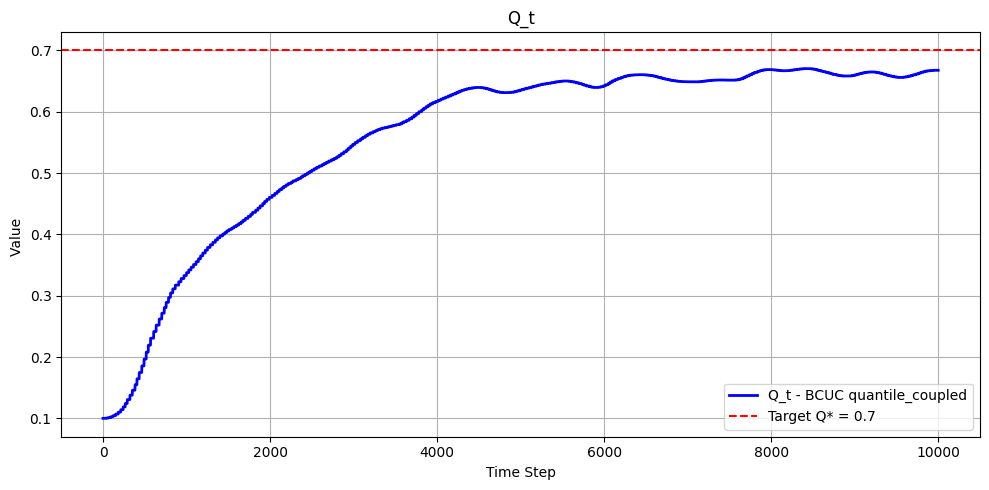

In [60]:
# plot_one(x = None, y=Q_vals, title="Process Noise over Timesteps", x_label="Time Step", y_label="Q_t", label="Q_t", dir_name=dir_name, fig_name="Q_t.png")
plt.figure(figsize=(10, 5))
plt.plot(Q_vals_qc, label="Q_t - BCUC quantile_coupled", color='blue', linewidth=2)
plt.axhline(y=0.7, color='red', linestyle='--', label="Target Q* = 0.7")
plt.xlabel("Time Step")
plt.ylabel("Value ")
plt.title("Q_t")

plt.legend()
plt.grid(True)
plt.tight_layout()
fig_name = "Q_t_over_time.png"
full_path = os.path.join(dir_name, fig_name)
plt.savefig(full_path, dpi=300, bbox_inches='tight')
plt.show()


In [11]:
Q_mean_last_k_qc = np.mean(Q_vals_qc[:])
print(Q_mean_last_k_qc)


0.5402366039309978


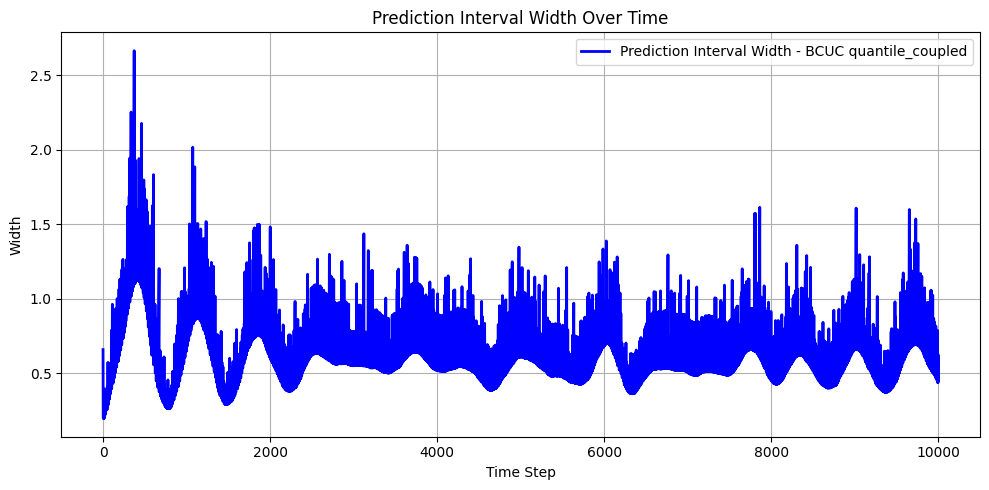

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(interval_widths_with_correction_qc, label="Prediction Interval Width - BCUC quantile_coupled", color='blue', linewidth=2)
plt.xlabel("Time Step")
plt.ylabel("Width")
plt.title("Prediction Interval Width Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
fig_name = "plot_interval_width.png"
full_path = os.path.join(dir_name, fig_name)
plt.savefig(full_path, dpi=300, bbox_inches='tight')
plt.show()

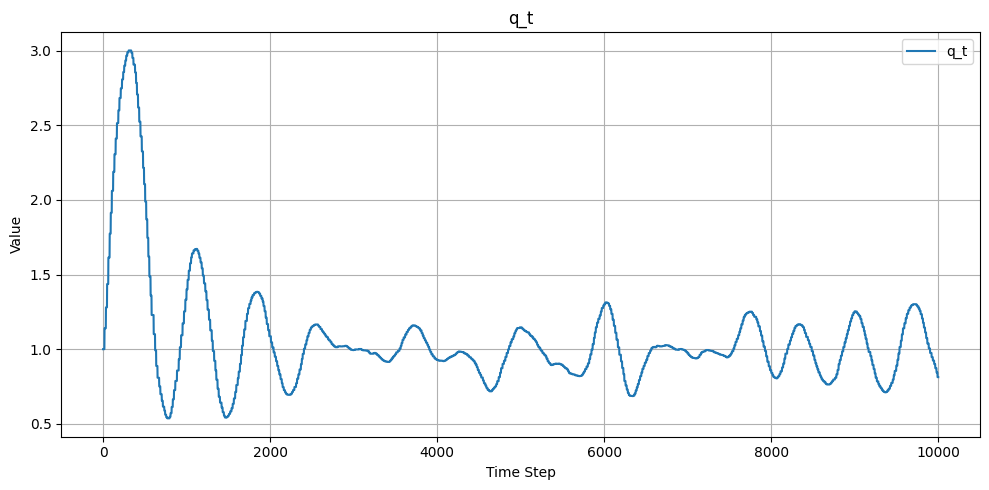

In [48]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(q_vals_qc)), q_vals_qc,  label="q_t")
# plt.yscale("log")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("q_t")
plt.legend()
plt.grid(True)
plt.tight_layout()
fig_name = "q_t.png"
full_path = os.path.join(dir_name, fig_name)
plt.savefig(full_path, dpi=300, bbox_inches='tight')
plt.show()

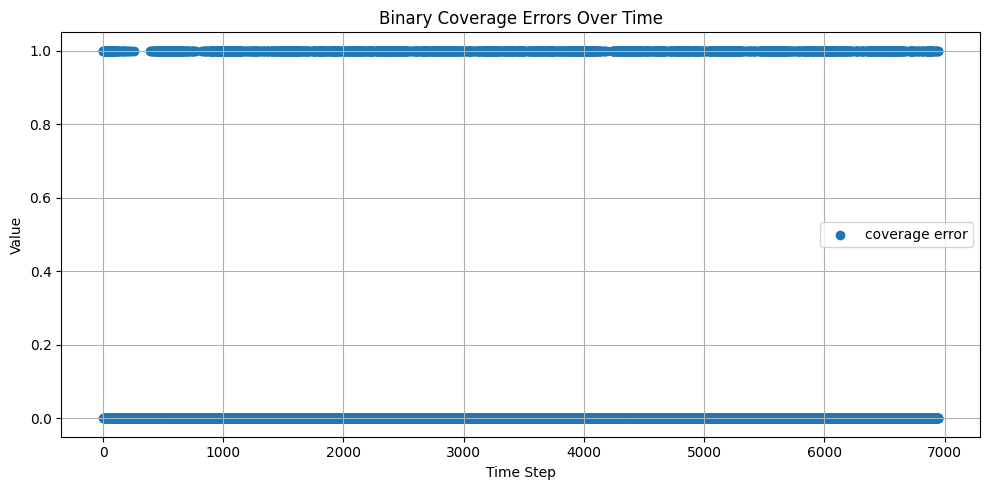

In [49]:
plt.figure(figsize=(10, 5))
time_steps = range(len(E_qc))  # or your actual time step data
plt.scatter(time_steps, E_qc, label="coverage error")
# plt.yscale("log")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Binary Coverage Errors Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
fig_name = "E_t.png"
full_path = os.path.join(dir_name, fig_name)
plt.savefig(full_path, dpi=300)
plt.show()

ValueError: x and y must be the same size

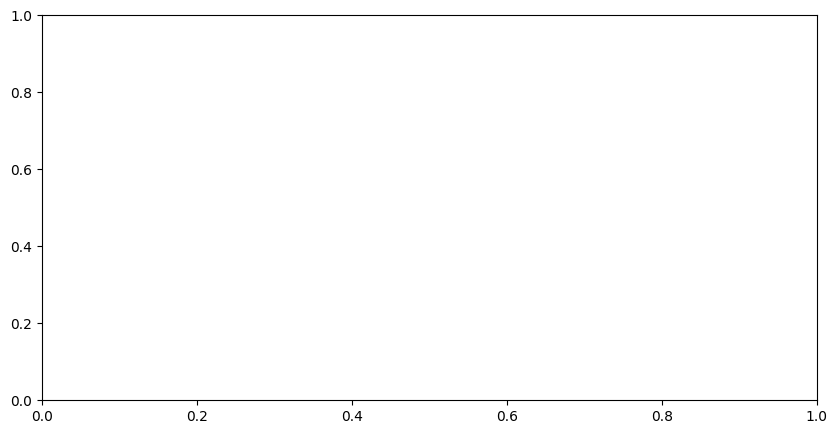

In [31]:
plt.figure(figsize=(10, 5))
time_steps = range(len(E))  # or your actual time step data
plt.scatter(E, Q_vals, label="coverage error")
# plt.yscale("log")
plt.xlabel("E_bar")
plt.ylabel("Q_t")
plt.title("Binary Coverage Errors Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
np.mean(E)

np.float64(0.2814814814814815)

In [25]:
sigma = np.array(sigma).flatten()
sigma

array([0.31462569, 0.00315418, 0.00315418, 0.00315418, 0.00315418,
       0.00444929, 0.00543535, 0.00626023, 0.00315418, 0.00315418,
       0.00315418, 0.00444929, 0.00315418, 0.00315418, 0.00444929,
       0.00543535, 0.00626023, 0.20565188, 0.20565188, 0.20565188,
       0.29009265, 0.20565188, 0.29009265, 0.35438334, 0.20565188,
       0.20565188, 0.20565188, 0.29009265, 0.20565188, 0.20565188,
       0.29009265, 0.20565188, 0.29009265, 0.35438334, 0.25916192,
       0.25916192, 0.25916192, 0.25916192, 0.36557393, 0.25916192,
       0.25916192, 0.36557393, 0.25916192, 0.36557393, 0.25916192,
       0.36557393, 0.25916192, 0.25916192, 0.29646541, 0.29646541,
       0.41819425, 0.29646541, 0.29646541, 0.29646541, 0.29646541,
       0.29646541, 0.29646541, 0.41819425, 0.51087498, 0.58840566,
       0.29646541, 0.29646541, 0.41819425, 0.32258126, 0.32258126,
       0.45503329, 0.32258126, 0.45503329, 0.32258126, 0.45503329,
       0.32258126, 0.32258126, 0.45503329, 0.55587833, 0.32258

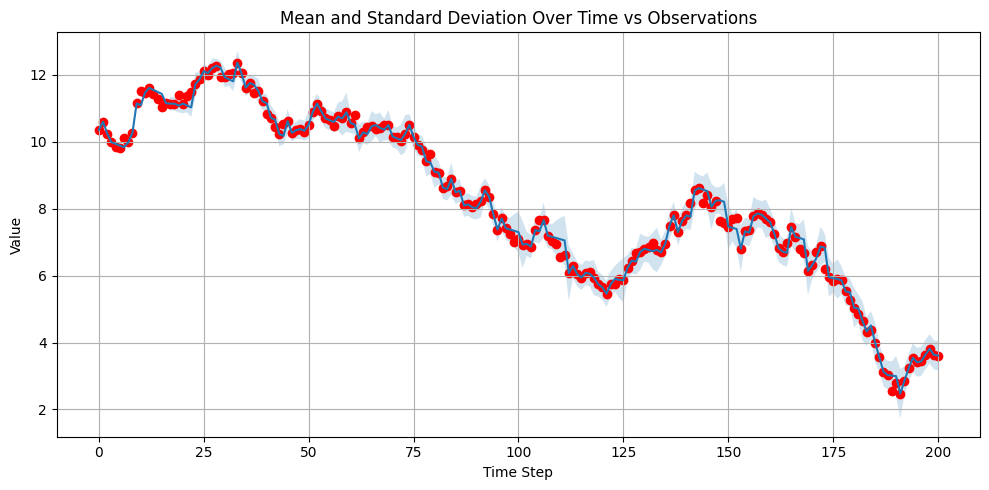

In [26]:
plt.figure(figsize=(10, 5))
ts = np.arange(len(meu)) 
plt.plot(ts, meu, label=" meu")
# plt.fill_between(ts, meu- std, meu + std, alpha=0.2, label="Confidence Interval")
# plt.yscale("log")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Mean and Standard Deviation Over Time vs Observations")
plt.grid(True)
plt.tight_layout()
plt.savefig("calibrated_distribution_over_time_vs_observation.png", dpi=300)
plt.fill_between(ts, meu - sigma, meu + sigma, alpha=0.2, label="Confidence Interval")
ts_new = np.arange(np.size(masked_observations))
# mask = ~np.isnan(masked_observations)
# ts_valid = ts_new[mask.flatten()]
# obs_valid = masked_observations[mask.flatten()]
# plt.scatter(ts_valid, obs_valid, color='red', label='Observations')
obs = data['observations']
plt.scatter(ts_new, obs, color='red', label='Observations')
plt.show()


In [23]:
mask = ~np.isnan(masked_observations)
obs_valid = masked_observations[mask.flatten()]
obs_valid.size

6948

201

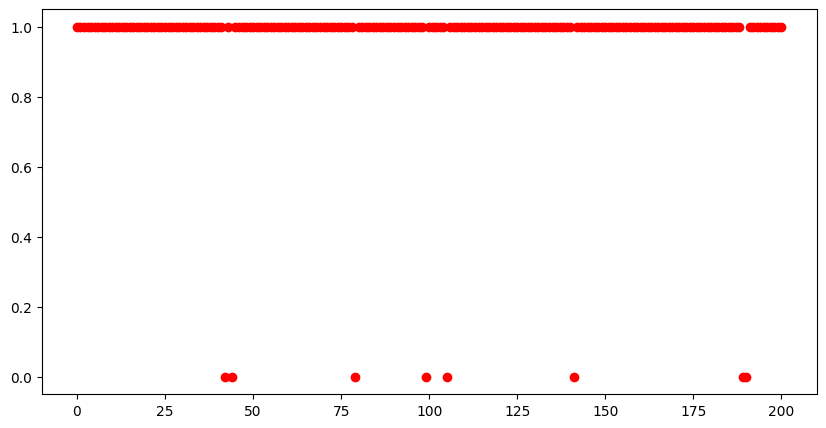

In [61]:
plt.figure(figsize=(10, 5))
plt.scatter(ts_new, within_band, color='red', label='Observations')
plt.show()



In [51]:
within_band.size

40200

In [71]:
np.arange(np.size(masked_observations))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
# FOR DIFFERENT NOTEBOOK - COMPARISON BETWEEN METHODS

# # NLL method (no quantile)
# cal_nll = NLLGD_Calibrator(initial_model=patient_1_model, eta_Q=1e-2, clip_grad=1.0, ema_beta=0.9)
# model_nll = cal_nll.calibrate_model(masked_observations, actions)
# print("NLLGD metrics:", cal_nll.get_metrics())

# # Your B-CUC variants already return the same keys via get_metrics()
# cal_bcuc_qc = BCUC_Calibrator(patient_1_model, mode="quantile_coupled")
# cal_bcuc_qc.calibrate_model(masked_observations, actions)
# print("BCUC (quantile_coupled):", cal_bcuc_qc.get_metrics())

# cal_bcuc_qf = BCUC_Calibrator(patient_1_model, mode="quantile_free")
# cal_bcuc_qf.calibrate_model(masked_observations, actions)
# print("BCUC (quantile_free):", cal_bcuc_qf.get_metrics())